In [8]:
import numpy as np
import numpy.random as rand
import numpy.linalg as la
import pylab as plt
from tqdm.auto import tqdm
from common import gsave, gload

def genX(G, n, d):
    return np.random.normal(size=(n, d)).dot(G)

def genXY(G, n, d, beta, sigma=0.1):
    X = genX(G, n, d)
    Y = X.dot(beta) + sigma*rand.normal(size=n)
    return X, Y

def testMSE(G, betaHat, beta, sigma):
    d = (betaHat - beta)
    return d.T.dot(G.T.dot(G)).dot(d)

def trainMSE(X, Y, betaHat):
    return np.mean((X.dot(betaHat) - Y)**2)

def reg_matrix(X, lamb=0.1):
    if lamb > 0:
        return la.inv(X.T.dot(X) + lamb*np.eye(X.shape[1])).dot(X.T)
    elif lamb == 0:
        return la.pinv(X)

In [9]:
def run(eigs, beta=None, sigma=0.2, ntrials=200, ns = range(1, 50, 1), facts = np.array(list(range(-8, 5, 1)))):
    ## varying regularizations

    d = len(eigs)
    G = np.diag(eigs) ## COVARIANCE = G^T G


    #facts = np.array(list(range(-10, 15, 2)) )
    #facts = np.array(list(range(-8, 5, 1))) # for isotropic

    lamb_bayes = d*sigma**2
    lambs = [0] + [lamb_bayes * (2.0)**i for i in facts]
    print(lambs)

    mses = np.empty((len(lambs), len(ns)))
    tr_mses = np.empty((len(lambs), len(ns)))
    norms = np.empty((len(lambs), len(ns)))

    if beta is None:
        beta = np.array([0]*(d-1) + [1])
    else:
        beta = np.array(beta)

    for i, n in enumerate(tqdm(ns)):
        for j, lamb in enumerate(lambs):
            t = []    
            nr = []
            tr = []
            for _ in range(ntrials):           
                X, yhat = genXY(G, n, d, beta, sigma=sigma)
                betaHat = reg_matrix(X, lamb=lamb).dot(yhat)
                mse = testMSE(G, betaHat, beta, sigma)
                tr_mse = trainMSE(X, yhat, betaHat)
                t.append(mse)
                tr.append(tr_mse)
                nr.append(np.linalg.norm(betaHat))

            mses[j, i] = np.mean(t)
            tr_mses[j, i] = np.mean(tr)
            norms[j, i] = np.mean(nr)


    ### Plot
    cm=plt.get_cmap('viridis')
    plt.style.use('seaborn-white')
    plt.figure(figsize=(15, 12))

    plt.plot(ns, mses[0, :], '.-',
              color=cm(0),
              alpha= 0.8,
              label='$\lambda = 0$')
    
    for i in range(len(facts)):
        plt.plot(ns, mses[i+1, :], '.-',
              color=cm(i / (len(facts)) ),
              alpha= 0.8,
              label='$\lambda$ = $\lambda_{bayes} \cdot 2^{%d}$' % facts[i])

    plt.legend()
    plt.ylim(0, 5)
    plt.xlabel('Num Samples')
    plt.ylabel('Expected Test Risk')
    plt.title('Test Risk for Regularized Regression $\sigma={%0.1f}$' % sigma)
    
    return ns, mses, tr_mses, norms, facts, lambs

In [ ]:
d = 30
eigs = [10] * (15) + [1] * (15)
beta = [0.2] + [0]*(d-2) + [1]

facts = np.array(list(range(-8, 10, 1)))
Q = (ns, mses, tr_mses, norms, facts, lambs) = run(eigs=eigs, beta=beta, sigma=0.5, facts=facts, ntrials=5000)

gsave(Q, 'gs://preetum/results/sdd/plots/nonisotropic_fine5k_tr')
#gsave(Q, 'gs://preetum/results/sdd/plots/nonisotropic_fine5k')
# Q: (ns, mses, tr_mses, norms, facts, lambs)

[0, 0.029296875, 0.05859375, 0.1171875, 0.234375, 0.46875, 0.9375, 1.875, 3.75, 7.5, 15.0, 30.0, 60.0, 120.0, 240.0, 480.0, 960.0, 1920.0, 3840.0]


[0, 0.48828125, 0.9765625, 1.953125, 3.90625, 7.8125, 15.625, 31.25, 62.5, 125.0, 250.0, 500.0, 1000.0, 2000.0]


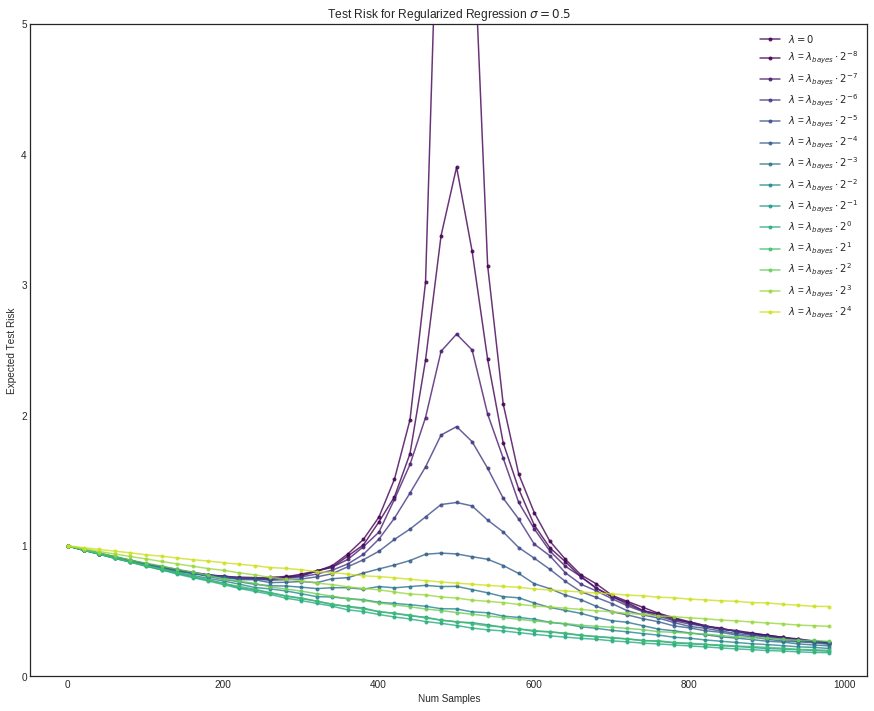

In [10]:
d = 500
eigs = np.ones(d)
beta = [1] + [0]*(d-1)
Q = run(eigs=eigs, beta=beta, sigma=0.5, ntrials=100, ns=range(1, 1000, 20))

gsave(Q, 'gs://preetum/results/sdd/plots/isotropic500_fine')
# Q: (ns, mses, norms, facts, lambs)

Text(0.5, 1.0, 'Train MSE for Regularized Regression')

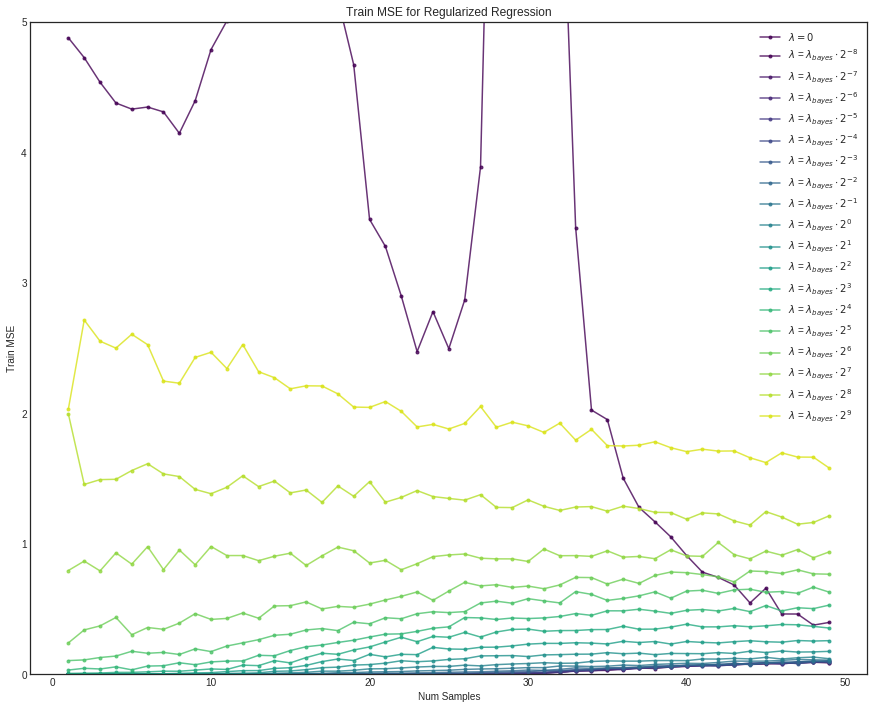

In [12]:
cm=plt.get_cmap('viridis')
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 12))

plt.plot(ns, mses[0, :], '.-',
          color=cm(0),
          alpha= 0.8,
          label='$\lambda = 0$')

for i in range(len(facts)):
    plt.plot(ns, tr_mses[i+1, :], '.-',
          color=cm(i / (len(facts)) ),
          alpha= 0.8,
          label='$\lambda$ = $\lambda_{bayes} \cdot 2^{%d}$' % facts[i])

plt.legend()
plt.ylim(0, 5)
plt.xlabel('Num Samples')
plt.ylabel('Train MSE')
plt.title('Train MSE for Regularized Regression')